In [ ]:
import numpy as np
import pandas as pd
import warnings
import time

import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.model_selection import train_test_split



In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
df = pd.read_excel('train.xlsx')
df

,Unnamed: 0,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Дата отмены,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница
0,0,20230428-6634-194809261,1,25700.0,0,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-20 20:39:15,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Отмена,Номер «Стандарт»,2,1
1,1,20220711-6634-144460018,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2022-06-18 14:17:02,NaT,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,1
2,2,20221204-16563-171020423,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2022-11-14 22:59:30,NaT,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Активный,Номер «Студия»,2,4
3,3,20230918-7491-223512699,1,10500.0,0,Внешняя система оплаты (С предоплатой),2023-09-08 15:55:53,NaT,2023-09-18 15:00:00,1,2023-09-19 12:00:00,Bronevik.com(new),Активный,Номер «Стандарт»,1,3
4,4,20230529-6634-200121971,1,28690.0,28690,Система быстрых платежей: Эквайринг ComfortBoo...,2023-05-20 19:54:13,NaT,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Активный,Номер «Люкс»,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,26169,20230310-7492-177993190,1,18240.0,9120,Банк. карта: Банк Россия (банк. карта),2023-01-07 17:45:18,NaT,2023-03-10 15:00:00,2,2023-03-12 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2
26170,26170,20230625-16563-206126520,1,69600.0,23200,Банк. карта: Банк Россия (банк. карта),2023-06-20 17:54:17,NaT,2023-06-25 15:00:00,3,2023-06-28 12:00:00,Официальный сайт,Активный,Номер «Студия»,3,4
26171,26171,20220624-7492-137587082,1,55600.0,13900,Банк. карта: Банк Россия (банк. карта),2022-05-08 19:24:05,NaT,2022-06-24 15:00:00,4,2022-06-28 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2
26172,26172,20220427-7491-125459150,1,6300.0,0,Гарантия банковской картой,2022-02-19 09:55:50,2022-04-16 23:14:35,2022-04-27 15:00:00,1,2022-04-28 12:00:00,booking.com,Отмена,Номер «Стандарт»,2,3


In [ ]:
'''Удаляем ненужные столбцы'''
del df["№ брони"]
del df["Unnamed: 0"]

In [ ]:
'''Заменяет дату отмены на отмену (0/1)'''
df['Дата отмены'] = df['Дата отмены'].fillna(0)
df['Отмена'] =  df['Дата отмены'].apply(lambda x: 0 if x==0 else 1)
del df['Дата отмены']

In [ ]:
'''Убираем единичные поля в статусе брони'''
df['Статус брони'] = df['Статус брони'].apply(lambda x: 'Активный' if x == 'Ожидается оплата' else ( 'Отмена' if x == 'Освоб. заранее' else x))

In [ ]:
'''Способы оплаты делим по типу платформы'''
df['Способ оплаты'] = df['Способ оплаты'].apply(lambda x: 'ComfortBooking' if x == 'Система быстрых платежей: Эквайринг ComfortBooking (Система быстрых платежей)' or x == 'Банк. карта [Кешбэк. МИР]: Эквайринг ComfortBooking (Банк. карта)' or x == 'Банк. карта: Эквайринг ComfortBooking (Банк. карта)' or x == 'Банк. карта (SberPay): Эквайринг ComfortBooking (Банк. карта) (SberPay)' or x == 'Банк. карта (Yandex Pay): Эквайринг ComfortBooking (Банк. карта) (Yandex Pay)' else ('TravelLine Pro' if x == 'Банк. карта [Кешбэк. МИР]: Эквайринг TravelLine Pro (Банк. карта)' else 'other'))

In [ ]:
df1 = df.apply(lambda col: col.astype('category').cat.codes if col.dtype == 'object' or col.dtype == 'datetime64[ns]'  else col)

In [ ]:
df1

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница,Отмена
0,1,25700.0,0,2,16638,494,3,485,26,2,25,2,1,1
1,1,24800.0,12400,2,7291,194,2,191,23,0,25,2,1,0
2,1,25800.0,12900,2,12253,340,2,337,23,0,27,2,4,0
3,1,10500.0,0,2,22189,643,1,628,9,0,25,1,3,0
4,1,28690.0,28690,0,17692,525,2,515,23,0,24,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,1,18240.0,9120,2,13310,442,2,433,23,0,25,2,2,0
26170,1,69600.0,23200,2,18791,556,3,545,23,0,27,3,4,0
26171,1,55600.0,13900,2,5762,177,4,176,23,0,25,2,2,0
26172,1,6300.0,0,2,1822,119,1,115,17,2,25,2,3,1


In [ ]:
import seaborn as sns

In [ ]:
'''from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

first_cloumn = "Гостей"
second_column = "Категория номера"

# Обучение линейной регрессии
model = LinearRegression()
model.fit(df[[first_cloumn]], df[second_column])

# Предсказания линейной модели
y_pred = model.predict(df[[first_cloumn]])

# Визуализация остатков
plt.scatter(df[first_cloumn], df[second_column] - y_pred)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel(first_cloumn)
plt.ylabel(second_column)
plt.title('Residuals of Linear Regression')
plt.show()

# Коэффициент детерминации и ошибка
r2 = r2_score(df[second_column], y_pred)
mse = mean_squared_error(df[second_column], y_pred)

print(f'R²: {r2}')
print(f'MSE: {mse}')'''

'from sklearn.linear_model import LinearRegression\nfrom sklearn.metrics import r2_score, mean_squared_error\n\nfirst_cloumn = "Гостей"\nsecond_column = "Категория номера"\n\n# Обучение линейной регрессии\nmodel = LinearRegression()\nmodel.fit(df[[first_cloumn]], df[second_column])\n\n# Предсказания линейной модели\ny_pred = model.predict(df[[first_cloumn]])\n\n# Визуализация остатков\nplt.scatter(df[first_cloumn], df[second_column] - y_pred)\nplt.axhline(y=0, color=\'r\', linestyle=\'--\')\nplt.xlabel(first_cloumn)\nplt.ylabel(second_column)\nplt.title(\'Residuals of Linear Regression\')\nplt.show()\n\n# Коэффициент детерминации и ошибка\nr2 = r2_score(df[second_column], y_pred)\nmse = mean_squared_error(df[second_column], y_pred)\n\nprint(f\'R²: {r2}\')\nprint(f\'MSE: {mse}\')'

In [ ]:
'''from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

first_cloumn = "Гостей"
second_column = "Категория номера"

# Подготовка данных для полиномиальной регрессии 2-й степени
poly = PolynomialFeatures(degree=3)
x_poly = poly.fit_transform(df[[first_cloumn]])

# Обучение модели
model = LinearRegression()
model.fit(x_poly, df[second_column])

# Предсказания
y_pred = model.predict(x_poly)

# Визуализация
plt.scatter(df[first_cloumn], df[second_column], label='Data')
plt.plot(df[first_cloumn], y_pred, color='red', label='Polynomial fit')
plt.xlabel(first_cloumn)
plt.ylabel(second_column)
plt.title('Polynomial Regression (degree 2)')
plt.legend()
plt.show()

# Коэффициент детерминации и ошибка
r2 = r2_score(df[second_column], y_pred)
mse = mean_squared_error(df[second_column], y_pred)

print(f'R²: {r2}')
print(f'MSE: {mse}')'''

'from sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.linear_model import LinearRegression\n\nfirst_cloumn = "Гостей"\nsecond_column = "Категория номера"\n\n# Подготовка данных для полиномиальной регрессии 2-й степени\npoly = PolynomialFeatures(degree=3)\nx_poly = poly.fit_transform(df[[first_cloumn]])\n\n# Обучение модели\nmodel = LinearRegression()\nmodel.fit(x_poly, df[second_column])\n\n# Предсказания\ny_pred = model.predict(x_poly)\n\n# Визуализация\nplt.scatter(df[first_cloumn], df[second_column], label=\'Data\')\nplt.plot(df[first_cloumn], y_pred, color=\'red\', label=\'Polynomial fit\')\nplt.xlabel(first_cloumn)\nplt.ylabel(second_column)\nplt.title(\'Polynomial Regression (degree 2)\')\nplt.legend()\nplt.show()\n\n# Коэффициент детерминации и ошибка\nr2 = r2_score(df[second_column], y_pred)\nmse = mean_squared_error(df[second_column], y_pred)\n\nprint(f\'R²: {r2}\')\nprint(f\'MSE: {mse}\')'

<Axes: >

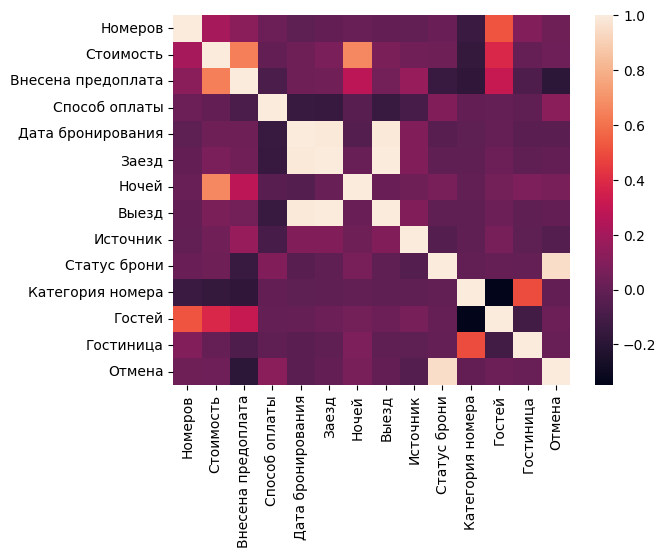

In [ ]:
sns.heatmap(df1.corr())

In [ ]:
df['Статус брони'].value_counts()

,count
Статус брони,
Активный,20982
Отмена,3405
Неподтвержденные,1787


In [ ]:
df['Статус брони']= df['Статус брони'].apply(lambda x: 'Активный' if x== 'Ожидается оплата' else ( 'Отмена' if x == 'Освоб. заранее' else x))
df

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница,Отмена
0,1,25700.0,0,other,2023-04-20 20:37:30,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Отмена,Номер «Стандарт»,2,1,1
1,1,24800.0,12400,other,2022-06-18 14:17:02,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,1,0
2,1,25800.0,12900,other,2022-11-14 22:59:30,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Активный,Номер «Студия»,2,4,0
3,1,10500.0,0,other,2023-09-08 15:55:53,2023-09-18 15:00:00,1,2023-09-19 12:00:00,Bronevik.com(new),Активный,Номер «Стандарт»,1,3,0
4,1,28690.0,28690,ComfortBooking,2023-05-20 19:54:13,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Активный,Номер «Люкс»,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,1,18240.0,9120,other,2023-01-07 17:45:18,2023-03-10 15:00:00,2,2023-03-12 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2,0
26170,1,69600.0,23200,other,2023-06-20 17:54:17,2023-06-25 15:00:00,3,2023-06-28 12:00:00,Официальный сайт,Активный,Номер «Студия»,3,4,0
26171,1,55600.0,13900,other,2022-05-08 19:24:05,2022-06-24 15:00:00,4,2022-06-28 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2,0
26172,1,6300.0,0,other,2022-02-19 09:55:50,2022-04-27 15:00:00,1,2022-04-28 12:00:00,booking.com,Отмена,Номер «Стандарт»,2,3,1


In [ ]:
df['Статус брони'].value_counts()

,count
Статус брони,
Активный,20982
Отмена,3405
Неподтвержденные,1787


In [ ]:
df['Способ оплаты'].value_counts()

,count
Способ оплаты,
other,21785
ComfortBooking,2775
TravelLine Pro,1614


In [ ]:
df['Способ оплаты'] = df['Способ оплаты'].apply(lambda x: 'ComfortBooking' if x == 'Система быстрых платежей: Эквайринг ComfortBooking (Система быстрых платежей)' or x == 'Банк. карта [Кешбэк. МИР]: Эквайринг ComfortBooking (Банк. карта)' or x == 'Банк. карта: Эквайринг ComfortBooking (Банк. карта)' or x == 'Банк. карта (SberPay): Эквайринг ComfortBooking (Банк. карта) (SberPay)' or x == 'Банк. карта (Yandex Pay): Эквайринг ComfortBooking (Банк. карта) (Yandex Pay)' else ('TravelLine Pro' if x == 'Банк. карта [Кешбэк. МИР]: Эквайринг TravelLine Pro (Банк. карта)' else 'other'))

In [ ]:
df['Способ оплаты'].value_counts()

,count
Способ оплаты,
other,26174


In [ ]:
df['Источник'].value_counts()

,count
Источник,
Официальный сайт,21077
Бронирование из экстранета,1306
Яндекс.Путешествия,1132
ostrovok.ru,733
booking.com,629
Программа лояльности,618
booking.com (Booking.com),205
Bronevik.com(new),141
OneTwoTrip,141


In [ ]:
df['Источник'] = df['Источник'].apply(lambda x:'Официальный сайт' if x == 'Официальный сайт' else 'неофициальный сайт' )

In [ ]:
df['Источник'].value_counts()

,count
Источник,
Официальный сайт,21077
неофициальный сайт,5097


In [ ]:
df

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница,Отмена
0,1,25700.0,0,other,2023-04-20 20:37:30,2023-04-28 15:00:00,3,2023-05-01 12:00:00,неофициальный сайт,Отмена,Номер «Стандарт»,2,1,1
1,1,24800.0,12400,other,2022-06-18 14:17:02,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,1,0
2,1,25800.0,12900,other,2022-11-14 22:59:30,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Активный,Номер «Студия»,2,4,0
3,1,10500.0,0,other,2023-09-08 15:55:53,2023-09-18 15:00:00,1,2023-09-19 12:00:00,неофициальный сайт,Активный,Номер «Стандарт»,1,3,0
4,1,28690.0,28690,other,2023-05-20 19:54:13,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Активный,Номер «Люкс»,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,1,18240.0,9120,other,2023-01-07 17:45:18,2023-03-10 15:00:00,2,2023-03-12 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2,0
26170,1,69600.0,23200,other,2023-06-20 17:54:17,2023-06-25 15:00:00,3,2023-06-28 12:00:00,Официальный сайт,Активный,Номер «Студия»,3,4,0
26171,1,55600.0,13900,other,2022-05-08 19:24:05,2022-06-24 15:00:00,4,2022-06-28 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2,0
26172,1,6300.0,0,other,2022-02-19 09:55:50,2022-04-27 15:00:00,1,2022-04-28 12:00:00,неофициальный сайт,Отмена,Номер «Стандарт»,2,3,1


In [ ]:

'''Смотрим на даты'''
df.iloc[:,4:7]

,Дата бронирования,Заезд,Ночей
0,2023-04-20 20:37:30,2023-04-28 15:00:00,3
1,2022-06-18 14:17:02,2022-07-11 15:00:00,2
2,2022-11-14 22:59:30,2022-12-04 15:00:00,2
3,2023-09-08 15:55:53,2023-09-18 15:00:00,1
4,2023-05-20 19:54:13,2023-05-29 15:00:00,2
...,...,...,...
26169,2023-01-07 17:45:18,2023-03-10 15:00:00,2
26170,2023-06-20 17:54:17,2023-06-25 15:00:00,3
26171,2022-05-08 19:24:05,2022-06-24 15:00:00,4
26172,2022-02-19 09:55:50,2022-04-27 15:00:00,1


In [ ]:
df['Месяц заезда'] = df['Заезд'].dt.month
df['Разница времени'] = (df['Заезд']-df['Дата бронирования']).dt.total_seconds()
''' ВЫделяем месяц бронирования, и время брони до заезда'''
df

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница,Отмена,Месяц заезда,Разница времени
0,1,25700.0,0,other,2023-04-20 20:37:30,2023-04-28 15:00:00,3,2023-05-01 12:00:00,неофициальный сайт,Отмена,Номер «Стандарт»,2,1,1,4,670950.0
1,1,24800.0,12400,other,2022-06-18 14:17:02,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,1,0,7,1989778.0
2,1,25800.0,12900,other,2022-11-14 22:59:30,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Активный,Номер «Студия»,2,4,0,12,1699230.0
3,1,10500.0,0,other,2023-09-08 15:55:53,2023-09-18 15:00:00,1,2023-09-19 12:00:00,неофициальный сайт,Активный,Номер «Стандарт»,1,3,0,9,860647.0
4,1,28690.0,28690,other,2023-05-20 19:54:13,2023-05-29 15:00:00,2,2023-05-31 12:00:00,Официальный сайт,Активный,Номер «Люкс»,4,1,0,5,759947.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,1,18240.0,9120,other,2023-01-07 17:45:18,2023-03-10 15:00:00,2,2023-03-12 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2,0,3,5346882.0
26170,1,69600.0,23200,other,2023-06-20 17:54:17,2023-06-25 15:00:00,3,2023-06-28 12:00:00,Официальный сайт,Активный,Номер «Студия»,3,4,0,6,421543.0
26171,1,55600.0,13900,other,2022-05-08 19:24:05,2022-06-24 15:00:00,4,2022-06-28 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,2,0,6,4044955.0
26172,1,6300.0,0,other,2022-02-19 09:55:50,2022-04-27 15:00:00,1,2022-04-28 12:00:00,неофициальный сайт,Отмена,Номер «Стандарт»,2,3,1,4,5807050.0


In [ ]:
del df['Заезд']
del df['Дата бронирования']
del df['Выезд']
'''Удаляем ненужные столбцы'''

'Удаляем ненужные столбцы'

In [ ]:
df

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Ночей,Источник,Статус брони,Категория номера,Гостей,Гостиница,Отмена,Месяц заезда,Разница времени
0,1,25700.0,0,other,3,неофициальный сайт,Отмена,Номер «Стандарт»,2,1,1,4,670950.0
1,1,24800.0,12400,other,2,Официальный сайт,Активный,Номер «Стандарт»,2,1,0,7,1989778.0
2,1,25800.0,12900,other,2,Официальный сайт,Активный,Номер «Студия»,2,4,0,12,1699230.0
3,1,10500.0,0,other,1,неофициальный сайт,Активный,Номер «Стандарт»,1,3,0,9,860647.0
4,1,28690.0,28690,other,2,Официальный сайт,Активный,Номер «Люкс»,4,1,0,5,759947.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,1,18240.0,9120,other,2,Официальный сайт,Активный,Номер «Стандарт»,2,2,0,3,5346882.0
26170,1,69600.0,23200,other,3,Официальный сайт,Активный,Номер «Студия»,3,4,0,6,421543.0
26171,1,55600.0,13900,other,4,Официальный сайт,Активный,Номер «Стандарт»,2,2,0,6,4044955.0
26172,1,6300.0,0,other,1,неофициальный сайт,Отмена,Номер «Стандарт»,2,3,1,4,5807050.0


In [ ]:
''' Средняя стоимость каждой гостиницы'''
df.groupby('Гостиница')['Стоимость'].mean()


,Стоимость
Гостиница,
1,40208.727042
2,29388.526873
3,28296.256558
4,58065.008632


In [ ]:
del df['Гостей']
del df['Номеров']
''' Удаляем количество гостей, поскольку почти пряямая зависимость к категории номера'''

' Удаляем количество гостей, поскольку почти пряямая зависимость к категории номера'

In [ ]:
df

,Стоимость,Внесена предоплата,Способ оплаты,Ночей,Источник,Статус брони,Категория номера,Гостиница,Отмена,Месяц заезда,Разница времени
0,25700.0,0,other,3,неофициальный сайт,Отмена,Номер «Стандарт»,1,1,4,670950.0
1,24800.0,12400,other,2,Официальный сайт,Активный,Номер «Стандарт»,1,0,7,1989778.0
2,25800.0,12900,other,2,Официальный сайт,Активный,Номер «Студия»,4,0,12,1699230.0
3,10500.0,0,other,1,неофициальный сайт,Активный,Номер «Стандарт»,3,0,9,860647.0
4,28690.0,28690,other,2,Официальный сайт,Активный,Номер «Люкс»,1,0,5,759947.0
...,...,...,...,...,...,...,...,...,...,...,...
26169,18240.0,9120,other,2,Официальный сайт,Активный,Номер «Стандарт»,2,0,3,5346882.0
26170,69600.0,23200,other,3,Официальный сайт,Активный,Номер «Студия»,4,0,6,421543.0
26171,55600.0,13900,other,4,Официальный сайт,Активный,Номер «Стандарт»,2,0,6,4044955.0
26172,6300.0,0,other,1,неофициальный сайт,Отмена,Номер «Стандарт»,3,1,4,5807050.0


In [ ]:
df['Категория номера'].unique()

array(['Номер «Стандарт»', 'Номер «Студия»', 'Номер «Люкс»',
       'Апартаменты с 2 спальнями с отдельным входом',
       'Коттедж с 3 спальнями',
       '1. Апартаменты с 2 спальнями с отдельным входом\n2. Апартаменты с 2 спальнями с отдельным входом',
       '1. Коттедж с 3 спальнями\n2. Коттедж с 3 спальнями',
       'Коттедж с 2 спальнями',
       '1. Номер «Стандарт»\n2. Номер «Стандарт»',
       '1. Номер «Стандарт»\n2. Номер «Стандарт»\n3. Номер «Стандарт»',
       'Номер «Стандарт» для маломобильных групп населения',
       '1. Номер «Люкс»\n2. Номер «Люкс»',
       '1. Номер «Стандарт»\n2. Номер «Люкс»',
       '1. Коттедж с 2 спальнями\n2. Коттедж с 2 спальнями\n3. Коттедж с 2 спальнями',
       '1. Коттедж с 2 спальнями\n2. Коттедж с 2 спальнями',
       '1. Номер «Стандарт»\n2. Номер «Стандарт»\n3. Номер «Стандарт»\n4. Номер «Стандарт» для маломобильных групп населения',
       '1. Коттедж с 3 спальнями\n2. Коттедж с 3 спальнями\n3. Коттедж с 3 спальнями',
       '1. Котте

In [ ]:
import re
unique_rooms = set()

# Регулярное выражение для поиска названий номеров
pattern = r'(Номер «.+?»|Апартаменты с \d+ спальнями с отдельным входом|Коттедж с \d+ спальнями|Коттедж с \d+ спальнями для маломобильных групп населения)'

for entry in df['Категория номера']:
    # Ищем все совпадения с заданным шаблоном
    matches = re.findall(pattern, entry)
    unique_rooms.update(matches)  # добавляем все найденные совпадения

# Сортируем и преобразуем в список
unique_rooms_list = sorted(unique_rooms)

In [ ]:
unique_rooms

{'Апартаменты с 2 спальнями с отдельным входом',
 'Коттедж с 2 спальнями',
 'Коттедж с 3 спальнями',
 'Номер «Люкс»',
 'Номер «Стандарт»',
 'Номер «Студия»'}

In [ ]:
def extract_categories(cat_str):
    return [line.strip() for line in cat_str.split('\n') if line.strip()]

# Создаем новый DataFrame, где каждая категория будет в отдельной строке
categories_expanded = df['Категория номера'].apply(extract_categories).explode()

# Получаем уникальные категории
unique_categories = categories_expanded.unique()

# Создаем словарь для хранения суммы индексов для каждой категории
index_sums = {category: 0 for category in unique_categories}

# Подсчет индексов для каждой категории
for i, category in enumerate(categories_expanded):
    index_sums[category] += (i + 1)  # Индексы начинаются с 1

# Обновляем значения в исходном DataFrame
def sum_indices(x):
    return sum(index_sums[cat] for cat in extract_categories(x) if cat in index_sums)

df['Категория номера'] = df['Категория номера'].apply(sum_indices)

In [ ]:
df['Категория номера'].unique()

array([223123617,  65128360,   9814373,  25818884,   9230577,    613382,
          238834,   9576228,   4925444,   5278214,    343071,    345634,
         2583434,     90617,     87267,   5282452,    275064,   2645833,
          966152,    187484,   5323594,    674752,   2687644,   3040414,
         4971332,   2455970,   2962373,   3106933])

## Добавляем новые признаки - погоду, ставку и сервис оплаты

### Погода

In [ ]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.9 MB/s eta 0:00:00


In [ ]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"start_date": "2024-09-06",
	"end_date": "2024-09-20",
	"hourly": "temperature_2m"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

Coordinates 52.5483283996582°N 13.407821655273438°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                         date  temperature_2m
0   2024-09-06 00:00:00+00:00       22.508501
1   2024-09-06 01:00:00+00:00       21.658501
2   2024-09-06 02:00:00+00:00       21.258501
3   2024-09-06 03:00:00+00:00       20.758501
4   2024-09-06 04:00:00+00:00       20.258501
..                        ...             ...
355 2024-09-20 19:00:00+00:00       16.158501
356 2024-09-20 20:00:00+00:00       15.508500
357 2024-09-20 21:00:00+00:00       15.008500
358 2024-09-20 22:00:00+00:00       14.408501
359 2024-09-20 23:00:00+00:00       13.908501

[360 rows x 2 columns]


Ставка и инфляция

In [ ]:
!pip install requests

In [ ]:
import requests
BASE_URL = 'http://www.cbr.ru/dataservice/' #источник данных

print("**** Каталог ****")
response = requests.get(f"{BASE_URL}/keyrate")
print(response)

**** Каталог ****
<Response [501]>


In [ ]:
df

,Стоимость,Внесена предоплата,Способ оплаты,Ночей,Источник,Статус брони,Категория номера,Гостиница,Отмена,Месяц заезда,Разница времени
0,25700.0,0,other,3,неофициальный сайт,Отмена,223123617,1,1,4,670950.0
1,24800.0,12400,other,2,Официальный сайт,Активный,223123617,1,0,7,1989778.0
2,25800.0,12900,other,2,Официальный сайт,Активный,65128360,4,0,12,1699230.0
3,10500.0,0,other,1,неофициальный сайт,Активный,223123617,3,0,9,860647.0
4,28690.0,28690,other,2,Официальный сайт,Активный,9814373,1,0,5,759947.0
...,...,...,...,...,...,...,...,...,...,...,...
26169,18240.0,9120,other,2,Официальный сайт,Активный,223123617,2,0,3,5346882.0
26170,69600.0,23200,other,3,Официальный сайт,Активный,65128360,4,0,6,421543.0
26171,55600.0,13900,other,4,Официальный сайт,Активный,223123617,2,0,6,4044955.0
26172,6300.0,0,other,1,неофициальный сайт,Отмена,223123617,3,1,4,5807050.0


OneHot

In [ ]:
df = df.drop(columns = ["Статус брони"])
ohe = OneHotEncoder(sparse=True,drop='first')
data_encoding = pd.concat([df.select_dtypes('object'),df["Гостиница"]], axis = 1)
data_numbers = df.select_dtypes(exclude = 'object')
ohe.fit(data_encoding)
features = ohe.get_feature_names_out()
codes = ohe.transform(data_encoding).toarray()
data_coded = pd.concat([data_numbers,pd.DataFrame(codes,columns = features).astype('int16')],axis = 1)

In [ ]:
data_coded

,Стоимость,Внесена предоплата,Ночей,Категория номера,Гостиница,Отмена,Месяц заезда,Разница времени,Источник_неофициальный сайт,Гостиница_2,Гостиница_3,Гостиница_4
0,25700.0,0,3,223123617,1,1,4,670950.0,1,0,0,0
1,24800.0,12400,2,223123617,1,0,7,1989778.0,0,0,0,0
2,25800.0,12900,2,65128360,4,0,12,1699230.0,0,0,0,1
3,10500.0,0,1,223123617,3,0,9,860647.0,1,0,1,0
4,28690.0,28690,2,9814373,1,0,5,759947.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
26169,18240.0,9120,2,223123617,2,0,3,5346882.0,0,1,0,0
26170,69600.0,23200,3,65128360,4,0,6,421543.0,0,0,0,1
26171,55600.0,13900,4,223123617,2,0,6,4044955.0,0,1,0,0
26172,6300.0,0,1,223123617,3,1,4,5807050.0,1,0,1,0


Ordinal encoding

In [ ]:
#df = df.apply(lambda col: col.astype('category').cat.codes if col.dtype == 'object' else col)

In [ ]:
#del df['Стоимость']

In [ ]:
df

,Стоимость,Внесена предоплата,Способ оплаты,Ночей,Источник,Категория номера,Гостиница,Отмена,Месяц заезда,Разница времени
0,25700.0,0,other,3,неофициальный сайт,223123617,1,1,4,670950.0
1,24800.0,12400,other,2,Официальный сайт,223123617,1,0,7,1989778.0
2,25800.0,12900,other,2,Официальный сайт,65128360,4,0,12,1699230.0
3,10500.0,0,other,1,неофициальный сайт,223123617,3,0,9,860647.0
4,28690.0,28690,other,2,Официальный сайт,9814373,1,0,5,759947.0
...,...,...,...,...,...,...,...,...,...,...
26169,18240.0,9120,other,2,Официальный сайт,223123617,2,0,3,5346882.0
26170,69600.0,23200,other,3,Официальный сайт,65128360,4,0,6,421543.0
26171,55600.0,13900,other,4,Официальный сайт,223123617,2,0,6,4044955.0
26172,6300.0,0,other,1,неофициальный сайт,223123617,3,1,4,5807050.0


In [ ]:
df

,Стоимость,Внесена предоплата,Способ оплаты,Ночей,Источник,Категория номера,Гостиница,Отмена,Месяц заезда,Разница времени
0,25700.0,0,other,3,неофициальный сайт,223123617,1,1,4,670950.0
1,24800.0,12400,other,2,Официальный сайт,223123617,1,0,7,1989778.0
2,25800.0,12900,other,2,Официальный сайт,65128360,4,0,12,1699230.0
3,10500.0,0,other,1,неофициальный сайт,223123617,3,0,9,860647.0
4,28690.0,28690,other,2,Официальный сайт,9814373,1,0,5,759947.0
...,...,...,...,...,...,...,...,...,...,...
26169,18240.0,9120,other,2,Официальный сайт,223123617,2,0,3,5346882.0
26170,69600.0,23200,other,3,Официальный сайт,65128360,4,0,6,421543.0
26171,55600.0,13900,other,4,Официальный сайт,223123617,2,0,6,4044955.0
26172,6300.0,0,other,1,неофициальный сайт,223123617,3,1,4,5807050.0


In [ ]:
df['Месяц заезда'] = pd.to_datetime(df['Месяц заезда']).astype(np.int64)

In [ ]:
df['Разница времени'] = pd.to_datetime(df['Разница времени']).astype(np.int64)

# Models

Преобразование датасета RobustScaler лучше обычного на SVM, но всё равно меньше топа. Провести one-hot категориальных, посмотреть кореляцию и распределение

In [ ]:
X = data_coded.drop(columns = ["Отмена"])
scl = RobustScaler()
X = scl.fit_transform(X)
y = data_coded["Отмена"]

X

array([[ 0.07089552, -0.90377113,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03731343, -0.09752926,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.07462687, -0.06501951,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.18656716,  0.        ,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.65298507, -0.90377113, -0.5       , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.02985075,  0.69570871, -0.5       , ...,  0.        ,
         0.        ,  0.        ]])

Логистическая регрессия (Понять что не так со скейлером)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state = 42)
X_trainl, X_val, y_trainl, y_val = train_test_split(X_train,y_train,test_size=0.25,random_state = 42)

In [ ]:
def c_best_selection(C_set, clf, X_t, y_t, X_val, y_val):
    auc_p_r = 0
    C = 1.0
    for C_i in C_set:
        clf.C = C_i
        clf.fit(X_t,y_t)
        a_x = clf.predict(X_val)

        precision, recall, th = precision_recall_curve(y_val, a_x)
        auc_precision_recall = auc(recall,precision)
        if auc_precision_recall > auc_p_r:
            auc_p_r = auc_precision_recall
            C = C_i
    print("C: ",C)
    return C

In [ ]:
best_c_LR = c_best_selection(np.arange(0.001,20,1), LogisticRegression(),X_trainl,y_trainl,X_val,y_val)

C:  1.001


In [ ]:
clf = LogisticRegression()
clf.C = best_c_LR
clf.fit(X_train,y_train)
a_x = clf.predict(X_test)

In [ ]:
precision, recall, th = precision_recall_curve(y_test,a_x)
auc_precision_recall = auc(recall,precision)

fpr,tpr,th_roc = roc_curve(y_test,a_x)
auc_roc = auc(fpr,tpr)


In [ ]:
print(auc_roc)

0.5904241340399653


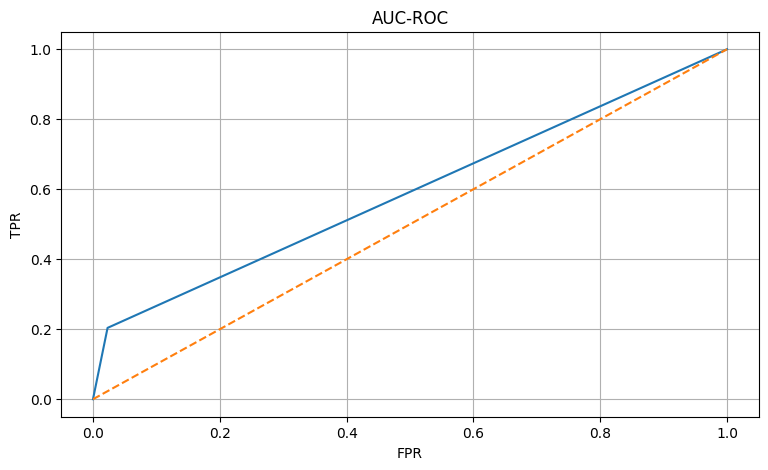

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(fpr,tpr,label = 'ROC')
plt.plot([0,1],[0,1],linestyle = '--')

plt.grid(True)
plt.title('AUC-ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

## SVM
Запустить со скейлером

In [ ]:
best_c_linearSVC = c_best_selection(np.arange(0.001,100,1),LinearSVC(),X_trainl,y_trainl,X_val,y_val)

C:  93.00099999999999


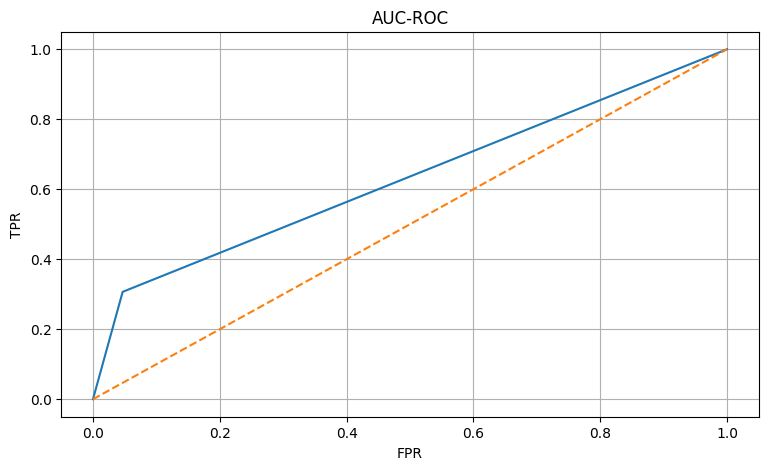

0.6299895737673223


In [ ]:
clf = LinearSVC()
clf.C = best_c_linearSVC
clf.fit(X_train,y_train)
a_x = clf.predict(X_test)
precision, recall, th = precision_recall_curve(y_test,a_x)
auc_precision_recall = auc(recall,precision)

fpr,tpr,th_roc = roc_curve(y_test,a_x)
auc_roc = auc(fpr,tpr)
plt.figure(figsize=(9,5))
plt.plot(fpr,tpr,label = 'ROC')
plt.plot([0,1],[0,1],linestyle = '--')

plt.grid(True)
plt.title('AUC-ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print(auc_roc)

## Catboost

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.5 MB/s eta 0:00:00


In [ ]:
df_cb = pd.read_excel("train.xlsx")
df_cb['Дата отмены'] = df_cb['Дата отмены'].fillna(0)
df_cb['Отмена'] =  df_cb['Дата отмены'].apply(lambda x: 0 if x==0 else 1)
del df_cb['Дата отмены']
del df_cb["Unnamed: 0"]
del df_cb["№ брони"]

In [ ]:
df_cb['Месяц заезда'] = df_cb['Заезд'].dt.month
df_cb['Разница времени'] = (df_cb['Заезд']-df_cb['Дата бронирования']).dt.total_seconds()
''' ВЫделяем месяц бронирования, и время брони до заезда'''
del df_cb['Заезд']
del df_cb['Дата бронирования']
del df_cb['Выезд']

In [ ]:
df_cb

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Ночей,Источник,Статус брони,Категория номера,Гостей,Гостиница,Отмена,Месяц заезда,Разница времени
0,1,25700.0,0,Внешняя система оплаты,3,Яндекс.Путешествия,Отмена,Номер «Стандарт»,2,1,1,4,670950.0
1,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2,Официальный сайт,Активный,Номер «Стандарт»,2,1,0,7,1989778.0
2,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2,Официальный сайт,Активный,Номер «Студия»,2,4,0,12,1699230.0
3,1,10500.0,0,Внешняя система оплаты (С предоплатой),1,Bronevik.com(new),Активный,Номер «Стандарт»,1,3,0,9,860647.0
4,1,28690.0,28690,Система быстрых платежей: Эквайринг ComfortBoo...,2,Официальный сайт,Активный,Номер «Люкс»,4,1,0,5,759947.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,1,18240.0,9120,Банк. карта: Банк Россия (банк. карта),2,Официальный сайт,Активный,Номер «Стандарт»,2,2,0,3,5346882.0
26170,1,69600.0,23200,Банк. карта: Банк Россия (банк. карта),3,Официальный сайт,Активный,Номер «Студия»,3,4,0,6,421543.0
26171,1,55600.0,13900,Банк. карта: Банк Россия (банк. карта),4,Официальный сайт,Активный,Номер «Стандарт»,2,2,0,6,4044955.0
26172,1,6300.0,0,Гарантия банковской картой,1,booking.com,Отмена,Номер «Стандарт»,2,3,1,4,5807050.0


In [ ]:

df_cb["Отношение"] = df_cb["Внесена предоплата"] / df_cb["Стоимость"]
X = df.drop(columns = ["Отмена"])
#scl = RobustScaler()
#X = scl.fit_transform(X)
y = df["Отмена"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state = 42)
X_trainl, X_val, y_trainl, y_val = train_test_split(X_train,y_train,test_size=0.25,random_state = 42)


In [ ]:
df_cb

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Ночей,Источник,Статус брони,Категория номера,Гостей,Гостиница,Отмена,Месяц заезда,Разница времени,Отношение
0,1,25700.0,0,Внешняя система оплаты,3,Яндекс.Путешествия,Отмена,Номер «Стандарт»,2,1,1,4,670950.0,0.000000
1,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2,Официальный сайт,Активный,Номер «Стандарт»,2,1,0,7,1989778.0,0.500000
2,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2,Официальный сайт,Активный,Номер «Студия»,2,4,0,12,1699230.0,0.500000
3,1,10500.0,0,Внешняя система оплаты (С предоплатой),1,Bronevik.com(new),Активный,Номер «Стандарт»,1,3,0,9,860647.0,0.000000
4,1,28690.0,28690,Система быстрых платежей: Эквайринг ComfortBoo...,2,Официальный сайт,Активный,Номер «Люкс»,4,1,0,5,759947.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,1,18240.0,9120,Банк. карта: Банк Россия (банк. карта),2,Официальный сайт,Активный,Номер «Стандарт»,2,2,0,3,5346882.0,0.500000
26170,1,69600.0,23200,Банк. карта: Банк Россия (банк. карта),3,Официальный сайт,Активный,Номер «Студия»,3,4,0,6,421543.0,0.333333
26171,1,55600.0,13900,Банк. карта: Банк Россия (банк. карта),4,Официальный сайт,Активный,Номер «Стандарт»,2,2,0,6,4044955.0,0.250000
26172,1,6300.0,0,Гарантия банковской картой,1,booking.com,Отмена,Номер «Стандарт»,2,3,1,4,5807050.0,0.000000


In [ ]:
model = CatBoostClassifier(iterations=1000, learning_rate=0.01, depth=5, verbose=0, l2_leaf_reg = 0.2, langevin = True)

In [ ]:
model.fit(X_train, y_train)
# Get predicted classes
a_x = model.predict(X_test)

fpr,tpr,th_roc = roc_curve(y_test,a_x)
auc_roc = auc(fpr,tpr)
plt.figure(figsize=(9,5))
plt.plot(fpr,tpr,label = 'ROC')
plt.plot([0,1],[0,1],linestyle = '--')

plt.grid(True)
plt.title('AUC-ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print(auc_roc)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=2]="other": Cannot convert 'b'other'' to float

XGBoost

In [ ]:
!pip install XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
model = xgb.XGBClassifier(objective='multi:softprob',
    num_class=2,
    max_depth=7,
    learning_rate=0.5,
    n_estimators=500,
    subsample = 0.8,             # Доля выборки данных
    colsample_bytree =0.8,      # Доля признаков на дереве
    gamma = 0,                   # Регуляризация разделений
    alpha = 1 )                   # L1-регуляризация)

NameError: name 'xgb' is not defined

In [ ]:
model.fit(X_train, y_train)
a_x = model.predict_proba(X_test)
a_x

In [ ]:
b_x = []
for i in a_x:
  b_x.append(a_x[i][1])
a_x = b_x


In [ ]:
fpr,tpr,th_roc = roc_curve(y_test,a_x)
auc_roc = auc(fpr,tpr)
plt.figure(figsize=(9,5))
plt.plot(fpr,tpr,label = 'ROC')
plt.plot([0,1],[0,1],linestyle = '--')

plt.grid(True)
plt.title('AUC-ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print(auc_roc)

Нейро

In [ ]:

import torch

X_train_n = torch.tensor(X_train, dtype=torch.float32)
y_train_n = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

ValueError: could not determine the shape of object type 'DataFrame'

In [ ]:
import torch.nn as nn

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(60, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [ ]:
import torch.optim as optim
import tqdm
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 250   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

# Test

In [ ]:
dft = pd.read_excel('test.xlsx')
dft

,Unnamed: 0,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница
0,0,20231129-16563-238946689,1,23750.0,23750,Банк. карта: Банк Россия (банк. карта),2023-11-28 10:34:43,2023-11-29 15:00:00,2,2023-12-01 12:00:00,Официальный сайт,Номер «Студия»,3,4
1,1,20221219-7491-174959103,1,15010.0,7505,Банк. карта: Банк Россия (банк. карта),2022-12-12 18:30:43,2022-12-19 15:00:00,2,2022-12-21 12:00:00,Официальный сайт,Номер «Стандарт»,2,3
2,2,20221211-6634-172724329,1,8400.0,8400,Отложенная электронная оплата: Банк Россия (ба...,2022-11-25 22:03:59,2022-12-11 15:00:00,1,2022-12-12 12:00:00,Официальный сайт,Номер «Стандарт»,2,1
3,3,20230821-6634-212247350,1,42500.0,42500,Банк. карта: Банк Россия (банк. карта),2023-07-18 15:45:46,2023-08-21 15:00:00,3,2023-08-24 12:00:00,Официальный сайт,Апартаменты с 2 спальнями с отдельным входом,4,1
4,4,20230326-6634-189784563,1,62500.0,11900,Система быстрых платежей: Эквайринг ComfortBoo...,2023-03-23 11:04:13,2023-03-26 15:00:00,5,2023-03-31 12:00:00,Официальный сайт,Номер «Стандарт»,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11213,11213,20220507-7492-130458541,1,50200.0,50200,Банк. карта [Кешбэк. МИР]: Эквайринг TravelLin...,2022-03-27 21:30:38,2022-05-07 15:00:00,2,2022-05-09 12:00:00,Официальный сайт,Номер «Студия»,4,2
11214,11214,20240217-6634-235901857,1,190100.0,43500,Система быстрых платежей: Эквайринг ComfortBoo...,2023-11-11 17:51:55,2024-02-16 15:00:00,5,2024-02-21 12:00:00,Официальный сайт,Коттедж с 2 спальнями,4,1
11215,11215,20220209-6634-124107676,1,42300.0,42300,Банк. карта: Банк Россия (банк. карта),2022-02-09 02:23:14,2022-02-09 15:00:00,1,2022-02-10 12:00:00,Официальный сайт,Коттедж с 3 спальнями,5,1
11216,11216,20230128-6634-179977236,1,27900.0,27900,Банк. карта: Банк Россия (банк. карта),2023-01-21 09:10:17,2023-01-28 15:00:00,1,2023-01-29 12:00:00,Официальный сайт,Апартаменты с 2 спальнями с отдельным входом,4,1


In [ ]:
del dft["№ брони"]
del dft["Unnamed: 0"]

In [ ]:
'''Способы оплаты делим по типу платформы'''
dft['Способ оплаты'] = dft['Способ оплаты'].apply(lambda x: 'ComfortBooking' if x == 'Система быстрых платежей: Эквайринг ComfortBooking (Система быстрых платежей)' or x == 'Банк. карта [Кешбэк. МИР]: Эквайринг ComfortBooking (Банк. карта)' or x == 'Банк. карта: Эквайринг ComfortBooking (Банк. карта)' or x == 'Банк. карта (SberPay): Эквайринг ComfortBooking (Банк. карта) (SberPay)' or x == 'Банк. карта (Yandex Pay): Эквайринг ComfortBooking (Банк. карта) (Yandex Pay)' else ('TravelLine Pro' if x == 'Банк. карта [Кешбэк. МИР]: Эквайринг TravelLine Pro (Банк. карта)' else 'other'))

In [ ]:
dft['Способ оплаты'] = dft['Способ оплаты'].apply(lambda x: 'ComfortBooking' if x == 'Система быстрых платежей: Эквайринг ComfortBooking (Система быстрых платежей)' or x == 'Банк. карта [Кешбэк. МИР]: Эквайринг ComfortBooking (Банк. карта)' or x == 'Банк. карта: Эквайринг ComfortBooking (Банк. карта)' or x == 'Банк. карта (SberPay): Эквайринг ComfortBooking (Банк. карта) (SberPay)' or x == 'Банк. карта (Yandex Pay): Эквайринг ComfortBooking (Банк. карта) (Yandex Pay)' else ('TravelLine Pro' if x == 'Банк. карта [Кешбэк. МИР]: Эквайринг TravelLine Pro (Банк. карта)' else 'other'))

In [ ]:
dft['Источник'] = dft['Источник'].apply(lambda x:'Официальный сайт' if x == 'Официальный сайт' else 'неофициальный сайт' )

In [ ]:
dft['Месяц заезда'] = dft['Заезд'].dt.month
dft['Разница времени'] = (dft['Заезд']-dft['Дата бронирования']).dt.total_seconds()

In [ ]:
del dft['Заезд']
del dft['Дата бронирования']
del dft['Выезд']
del dft['Гостей']
del dft['Номеров']

In [ ]:
dft = dft.apply(lambda col: col.astype('category').cat.codes if col.dtype == 'object' else col)

In [ ]:
dft

,Стоимость,Внесена предоплата,Способ оплаты,Ночей,Источник,Категория номера,Гостиница,Месяц заезда,Разница времени
0,23750.0,23750,0,2,0,25,4,11,102317.0
1,15010.0,7505,0,2,0,23,3,12,592157.0
2,8400.0,8400,0,1,0,23,1,12,1356961.0
3,42500.0,42500,0,3,0,19,1,8,2934854.0
4,62500.0,11900,0,5,0,23,1,3,273347.0
...,...,...,...,...,...,...,...,...,...
11213,50200.0,50200,0,2,0,25,2,5,3518962.0
11214,190100.0,43500,0,5,0,20,1,2,8370485.0
11215,42300.0,42300,0,1,0,21,1,2,45406.0
11216,27900.0,27900,0,1,0,19,1,1,625783.0


In [ ]:
ans = clf.predict(dft)
pd.DataFrame(ans).to_csv("attempt1.csv",index = False)
pd.DataFrame(ans)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


ValueError: X has 9 features, but LinearSVC is expecting 11 features as input.